In [1]:
!pip install -q kaggle


In [2]:
!mkdir ~/.kaggle #this token will expire after some time

In [3]:
!cp kaggle.json ~/.kaggle

In [4]:
!kaggle datasets download -d tawsifurrahman/covid19-radiography-database

 97% 758M/778M [00:04<00:00, 172MB/s]
100% 778M/778M [00:04<00:00, 177MB/s]


In [5]:
!unzip /content/covid19-radiography-database.zip

Streaming output truncated to the last 5000 lines.
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7921.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7922.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7923.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7924.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7925.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7926.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7927.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7928.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7929.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-793.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7930.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7931.png  
  inflating: COVID-19_Radiography_Dataset/Normal/masks/Normal-7932.png  
 

# Data Collection

In [6]:
!mkdir X-Rays

In [7]:
!mkdir -p /content/X-Rays/COVID
!mkdir -p /content/X-Rays/LUNG_OPACITY
!mkdir -p /content/X-Rays/NORMAL
!mkdir -p /content/X-Rays/PNEUMONIA

In [14]:
!cp /content/COVID-19_Radiography_Dataset/COVID/images/*.png /content/X-Rays/COVID
!cp /content/COVID-19_Radiography_Dataset/Normal/images/*.png /content/X-Rays/NORMAL
!cp /content/COVID-19_Radiography_Dataset/Lung_Opacity/images/*.png /content/X-Rays/LUNG_OPACITY
!cp /content/COVID-19_Radiography_Dataset/Viral_Pneumonia/images/*.png /content/X-Rays/PNEUMONIA


# Data Preprocessing

In [15]:
import os
dataset_dir = "/content/X-Rays"
categories = ["COVID", "LUNG_OPACITY", "NORMAL", "PNEUMONIA"]
image_counts = {}

for category in categories:
    category_path = os.path.join(dataset_dir, category)
    image_counts[category] = len(os.listdir(category_path))

print(image_counts)

{'COVID': 3616, 'LUNG_OPACITY': 6012, 'NORMAL': 10192, 'PNEUMONIA': 1345}


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

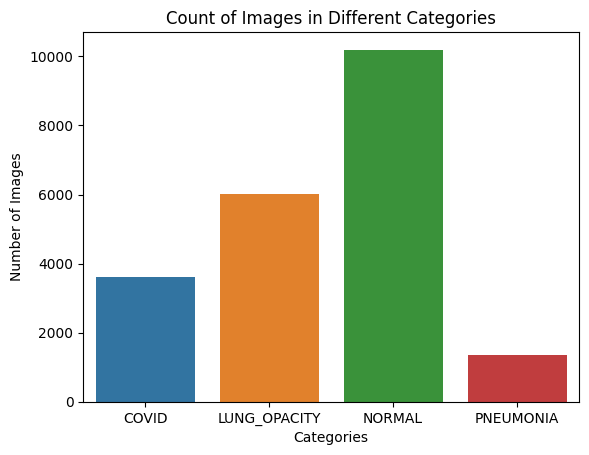

In [17]:
sns.barplot(x=list(image_counts.keys()), y=list(image_counts.values()))

plt.xlabel("Categories")
plt.ylabel("Number of Images")
plt.title("Count of Images in Different Categories")
plt.show()

# Data Augmentation

In [18]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_path="/content/X-Rays"

In [19]:
train_datagen = ImageDataGenerator(rescale=1/255,zoom_range=0.2,shear_range=0.2,validation_split=0.2)

In [21]:
train=train_datagen.flow_from_directory(train_path,target_size=(224,224),batch_size=16,subset='training',class_mode='categorical')# input pixels of images trained for VGGnet
test=train_datagen.flow_from_directory(train_path,target_size=(224,224),batch_size=16,subset='validation',class_mode='categorical')

Found 16933 images belonging to 4 classes.
Found 4232 images belonging to 4 classes.


#VGG-16 model

In [22]:
from tensorflow.keras.applications.vgg16 import VGG16 #Vgg 1000 class classifier trained with Imagenet datset
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Model

In [23]:
vgg = VGG16(include_top=False,input_shape=(224,224,3))#trained input layer is removed

58889256/58889256 [==============================] - 0s 0us/step


# Check the model architecture(layers)

In [24]:
for layer in vgg.layers:
  print(layer)

# Not building the model using the pre-built one

In [25]:
for layer in vgg.layers:
  layer.trainable= False

In [26]:
x= Flatten()(vgg.output) #vectorizing the output from vgg 16

In [27]:
output=Dense(4,activation='softmax')(x) #fixing the output layer

# Model definition

In [28]:
vgg16= Model(vgg.input,output)

In [29]:
vgg16.compile(loss='categorical_crossentropy',optimizer='adam',metrics=(['accuracy']))

In [30]:
vgg16.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [32]:
vgg_hist=vgg16.fit(train,validation_data=test,epochs=10,steps_per_epoch=len(train),validation_steps=len(test))

Epoch 1/10
1059/1059 [==============================] - 319s 301ms/step - loss: 0.4958 - accuracy: 0.8199 - val_loss: 0.4261 - val_accuracy: 0.8372
Epoch 2/10
1059/1059 [==============================] - 357s 337ms/step - loss: 0.4116 - accuracy: 0.8593 - val_loss: 0.3393 - val_accuracy: 0.8837
Epoch 3/10
1059/1059 [==============================] - 316s 298ms/step - loss: 0.3798 - accuracy: 0.8719 - val_loss: 0.4221 - val_accuracy: 0.8726
Epoch 4/10
1059/1059 [==============================] - 324s 306ms/step - loss: 0.3604 - accuracy: 0.8799 - val_loss: 0.3405 - val_accuracy: 0.8887
Epoch 5/10
1059/1059 [==============================] - 345s 326ms/step - loss: 0.3341 - accuracy: 0.8877 - val_loss: 0.5949 - val_accuracy: 0.8573
Epoch 6/10
1059/1059 [==============================] - 322s 304ms/step - loss: 0.3206 - accuracy: 0.8899 - val_loss: 0.4494 - val_accuracy: 0.8741
Epoch 7/10
1059/1059 [==============================] - 317s 300ms/step - loss: 0.2929 - accuracy: 0.9001 - val_

In [45]:
test_datagen = ImageDataGenerator(rescale=1./255,validation_split=0.2)
test_generator = test_datagen.flow_from_directory(
    "/content/X-Rays",
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',  # Change to 'binary' for binary classification
    shuffle=False,  # Ensure no shuffling for consistent evaluation
    subset='validation'
)

Found 4232 images belonging to 4 classes.


In [47]:
y_pred = vgg16.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy: {:.2f}%".format(accuracy * 100))

67/67 [==============================] - 35s 392ms/step
Accuracy: 89.22%


In [52]:
from sklearn.metrics import classification_report
class_names = ['COVID', 'LUNG_OPACITY','NORMAL', 'PNEUMONIA']
report = classification_report(y_true, y_pred_classes, target_names=class_names)
print(report)

              precision    recall  f1-score   support

       COVID       0.93      0.86      0.90       723
LUNG_OPACITY       0.95      0.77      0.85      1202
      NORMAL       0.86      0.97      0.91      2038
   PNEUMONIA       0.90      0.92      0.91       269

    accuracy                           0.89      4232
   macro avg       0.91      0.88      0.89      4232
weighted avg       0.90      0.89      0.89      4232



# ResNet50

In [53]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.layers import Dense,Flatten
from tensorflow.keras.models import Model


In [54]:
res = ResNet50(include_top=False,input_shape=(224,224,3))#trained input layer is removed

94765736/94765736 [==============================] - 1s 0us/step


In [55]:
c=0
for layer in res.layers:
  c+=1
  print(layer)
print(c)
len(res.layers)

175


175

In [56]:
for layer in res.layers:
  layer.trainable=False

In [57]:
x = Flatten()(res.output)

In [58]:
output= Dense(4,activation='softmax')(x)

In [59]:
res_model =Model(res.input,output)

In [60]:
res_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=(['accuracy']))

In [61]:
res_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                        

In [62]:
res_model.fit(train,validation_data=test,epochs=10,steps_per_epoch=len(train),validation_steps=len(test))

Epoch 1/10
1059/1059 [==============================] - 362s 334ms/step - loss: 1.4909 - accuracy: 0.5212 - val_loss: 0.8562 - val_accuracy: 0.6430
Epoch 2/10
1059/1059 [==============================] - 322s 304ms/step - loss: 1.3279 - accuracy: 0.5841 - val_loss: 0.8243 - val_accuracy: 0.6940
Epoch 3/10
1059/1059 [==============================] - 320s 302ms/step - loss: 1.3090 - accuracy: 0.6110 - val_loss: 1.1104 - val_accuracy: 0.6371
Epoch 4/10
1059/1059 [==============================] - 315s 298ms/step - loss: 1.2141 - accuracy: 0.6271 - val_loss: 1.2947 - val_accuracy: 0.6841
Epoch 5/10
1059/1059 [==============================] - 314s 296ms/step - loss: 1.2356 - accuracy: 0.6332 - val_loss: 1.9167 - val_accuracy: 0.5043
Epoch 6/10
1059/1059 [==============================] - 312s 295ms/step - loss: 1.1598 - accuracy: 0.6487 - val_loss: 0.9586 - val_accuracy: 0.6758
Epoch 7/10
1059/1059 [==============================] - 310s 293ms/step - loss: 1.2572 - accuracy: 0.6425 - val_

In [63]:
y_pred = res_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

accuracy = accuracy_score(y_true, y_pred_classes)
print("Accuracy: {:.2f}%".format(accuracy * 100))

67/67 [==============================] - 20s 252ms/step
Accuracy: 64.60%
